In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

a,b,c=[gum.LabelizedVariable(s,s,2) for s in "abc"]

# potential algebra

In [2]:
p1=gum.Potential().add(a).add(b).fillWith([1,2,3,4]).normalize()
gnb.showPotential(p1)

In [3]:
p2=gum.Potential().add(b).add(c).fillWith([4,5,2,3]).normalize()
gnb.showPotential(p2)

In [4]:
gnb.showPotential(p1+p2)

In [5]:
p3=p1+p2 
gnb.showPotential(p3/p3.margSumOut(["b"]))

In [6]:
print(p3)
p4=gum.Potential()+p3
print(p4)


<b:0|c:0|a:0> :: 0.385714 /<b:1|c:0|a:0> :: 0.657143 /<b:0|c:1|a:0> :: 0.242857 /<b:1|c:1|a:0> :: 0.514286 /<b:0|c:0|a:1> :: 0.485714 /<b:1|c:0|a:1> :: 0.757143 /<b:0|c:1|a:1> :: 0.342857 /<b:1|c:1|a:1> :: 0.614286
<b:0|c:0|a:0> :: 0.385714 /<b:1|c:0|a:0> :: 0.657143 /<b:0|c:1|a:0> :: 0.242857 /<b:1|c:1|a:0> :: 0.514286 /<b:0|c:0|a:1> :: 0.485714 /<b:1|c:0|a:1> :: 0.757143 /<b:0|c:1|a:1> :: 0.342857 /<b:1|c:1|a:1> :: 0.614286


# bayes formula

In [7]:
bn=gum.BayesNet()
na,nb,nc=[bn.add(s,3) for s in "abc"]

bn.addArc(na,nc)
bn.addArc(nb,nc)

bn.generateCPTs()

gnb.showBN(bn)

In such a small bayes net, we can directly manipulate $P(a,b,c)$. For instance : $$P(b|c)=\frac{\sum_{a} P(a,b,c)}{\sum_{a,b} P(a,b,c)}$$

In [8]:
pABC=bn.cpt(na)*bn.cpt(nb)*bn.cpt(nc)
pBgivenC=(pABC.margSumOut(["a"])/pABC.margSumOut(["a","b"])).putFirst("b")

gnb.showPotential(pBgivenC)

# Joint, marginal probability, likelihood
Let's compute the joint probability $P(A,B)$ from $P(A,B,C)$

In [9]:
pAC=pABC.margSumOut(["b"])
print("pAC really is a probability : it sums to {}".format(pAC.sum()))
gnb.showPotential(pAC)


pAC really is a probability : it sums to 1.0


## Computing $p(A)$

In [10]:
gnb.showPotential(pAC.margSumOut(["c"]))

## Computing $p(A |C=1)$
It is easy to compute $p(A, C=1)$

In [11]:
gnb.showPotential(pAC.extract({"c":1}))

Moreover, we know that $P(C=1)=\sum_A P(A,C=1)$

In [12]:
pAC.extract({"c":1}).sum()

0.29258359286660085

Now we can compute $p(A|C=1)=\frac{P(A,C=1)}{p(C=1)}$

In [13]:
gnb.showPotential(pAC.extract({"c":1}).normalize())

## Computing $P(A|C)$
$P(A|C)$ is represented by a matrix that verifies $p(A|C)=\frac{P(A,C)}{P(C}$

In [14]:
pAgivenC=pAC/pAC.margSumIn(["c"])
gnb.showPotential(pAgivenC)

$P(A|C=1)$ is a row in this matrix

In [15]:
gnb.showPotential(pAgivenC.extract({'c':1}))

## Likelihood $P(A=2|C)$

A likelihood can also be found in this matrix.

In [16]:
gnb.showPotential(pAgivenC.extract({'a':2}))

A likelihood does not have to sum to 1. It is not relevant to normalize it.

In [17]:
gnb.showPotential(pAgivenC.margSumIn(["a"]))

# entropy of potential

In [18]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import numpy as np

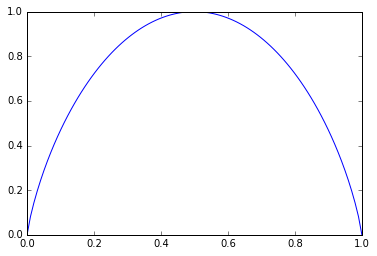

In [19]:
p1=gum.Potential().add(a)
x = np.linspace(0, 1, 100)
plt.plot(x,[p1.fillWith([p,1-p]).entropy() for p in x])
plt.show()

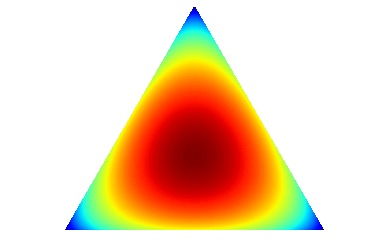

In [20]:
t=gum.LabelizedVariable('t','t',3)
p1=gum.Potential().add(t)

def entrop(bc):
    """
    bc is a list [a,b,c] close to a distribution 
    (normalized just to be sure)
    """
    return p1.fillWith(bc).normalize().entropy()

import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    """
    From 2D Cartesian coordinates to barycentric.
    """
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)
    
def draw_entropy(nlevels=200, subdiv=6, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [entrop(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
draw_entropy()